In [1]:
#import the working library
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
%matplotlib inline

In [2]:
#read tickers as specified in excel in addition to market 
all_tickers = pd.read_excel('mapping.xlsx')[['Ticker', 'Market']]
#list all tickers
all_tickers

,Ticker,Market
0,ARGT,Emerging
1,EWA,Developed
2,EWO,Developed
3,EWK,Developed
4,EWZ,Emerging
5,EWC,Developed
6,ECH,Emerging
7,MCHI,Emerging
8,ICOL,Emerging
9,EDEN,Developed


In [3]:
factor_description = pd.read_excel('factor description.xlsx', index_col='Short Name')
factor_description

,Name,Category
Short Name,,
mom_21,Short-term Absolute Momentum (21-trading day),Technical
mom_63,Medium-term Absolute Momentum (63-trading day),Technical
mom_252,Long-term Absolute Momentum (252-trading day),Technical
mr_21,Percentage over Short-term Moving Average (21-...,Technical
mr_63,Percentage over Medium-term Moving Average (63...,Technical
mr_252,Percentage over Long-term Moving Average (252-...,Technical
div_yield,Dividend Yield,Fundamental
pb,Price/Book Ratio,Fundamental
pe,Price/Earning Ratio,Fundamental


In [4]:
#specified factor and date
start_date_train = '2015-01-01'
end_date_train = '2018-12-31'
start_date_test = '2019-01-01'
end_date_test = '2019-12-31'

# Technical Factors

In [6]:
factors = ['mom_252', 'mom_63', 'mom_21', 
           'mr_252', 'mr_63', 'mr_21']

Long-term Absolute Momentum (252-trading day)


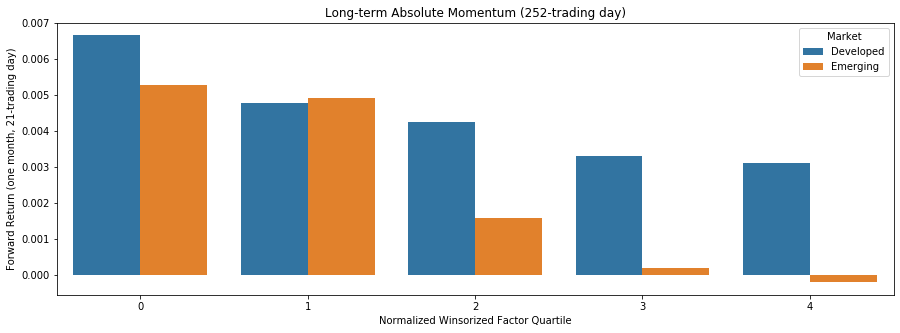

Medium-term Absolute Momentum (63-trading day)


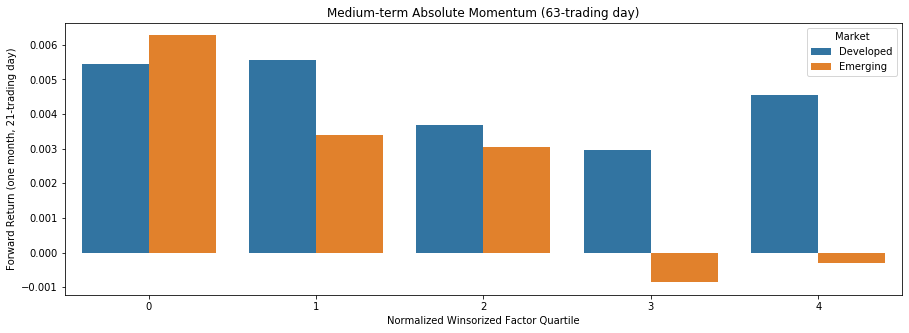

Short-term Absolute Momentum (21-trading day)


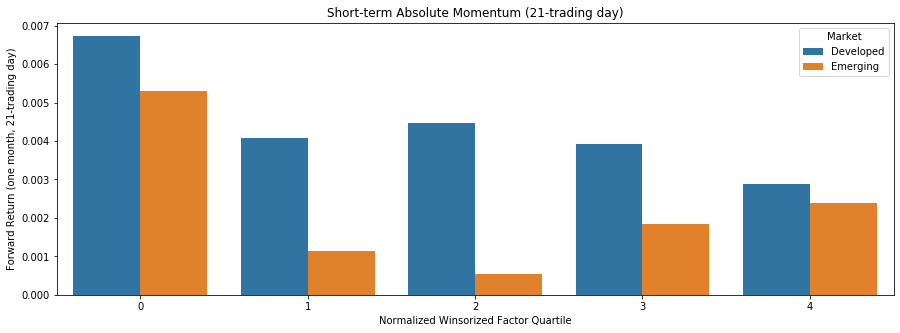

Percentage over Long-term Moving Average (252-trading day)


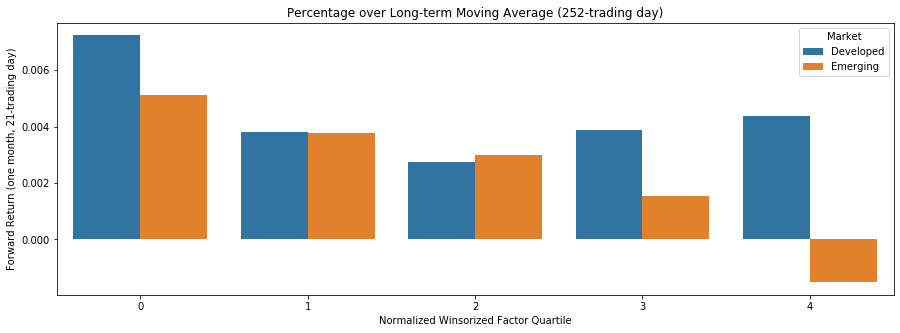

Percentage over Medium-term Moving Average (63-trading day)


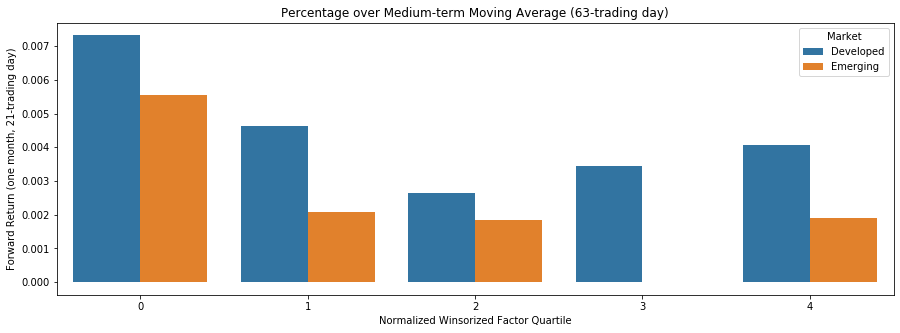

Percentage over Short-term Moving Average (21-trading day)


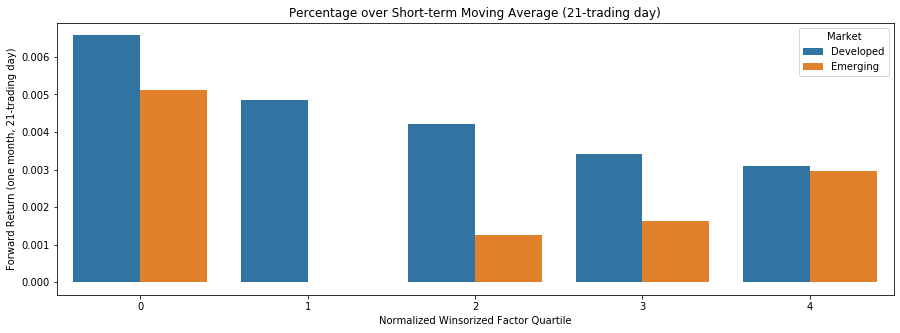

In [7]:
for factor_to_analyze in factors:
    description_factor_to_analyze = factor_description.loc[factor_to_analyze, 'Name']
    print(description_factor_to_analyze)

    #list all etf in datafrome
    all_etf_combined_df = pd.DataFrame()

    #going throw each etf forward return 
    for file in os.listdir('forward return'):
        fr_df = pd.read_csv('forward return/'+file, index_col='Date')
        fr_df['Ticker'] = file[:-4]
        try:
            factor_df = pd.read_csv('factor data/'+factor_to_analyze+'/'+file[:-4]+'.csv', index_col='Date')
            combined_df = fr_df.join(factor_df).rename({factor_to_analyze: 'Factor'}, axis=1)
            combined_df['Factor'] = combined_df['Factor'].fillna(method='ffill')
            all_etf_combined_df = pd.concat([all_etf_combined_df, combined_df.dropna().reset_index()], axis=0, ignore_index=True)
        except:
            continue

    all_etf_combined_df = all_etf_combined_df.join(all_tickers.set_index('Ticker'), on='Ticker').dropna()
    all_etf_combined_df = all_etf_combined_df.sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])[start_date_train:end_date_train]
    all_etf_combined_df['Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor Quartile'] = -1

    #combine all factors
    for date in all_etf_combined_df.index.get_level_values(0).unique():
        for market in ['Developed', 'Emerging']:
            n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]
            all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['Factor'], limits=1/n_etf*2)
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'])
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor Quartile'] = pd.qcut(all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'], 5, labels=False)
    # all_etf_combined_df.loc['2015-01-02'].drop('f_rtn', axis=1)
    #factor quantile study by developed and emerging market
    summary_df = all_etf_combined_df.reset_index().groupby(['Market', 'Normalized Winsorized Factor Quartile']).mean()[['f_rtn']]
    plt.figure(figsize=(15, 5))
    sns.barplot(x='Normalized Winsorized Factor Quartile', 
                y='Forward Return (one month, 21-trading day)', 
                hue='Market', 
                data=summary_df.reset_index().rename(factor_description['Name'].to_dict(), axis=1))
    plt.title(description_factor_to_analyze)
    plt.savefig('factor analysis results/'+factor_to_analyze+'.png')
    plt.show()
    summary_df.rename(factor_description['Name'].to_dict(), axis=1).T.to_excel('factor analysis results/'+factor_to_analyze+'.xlsx')

# Fundamental Factors

In [8]:
factors = ['div_yield', 'pe', 'pb', 'pcf']

Dividend Yield


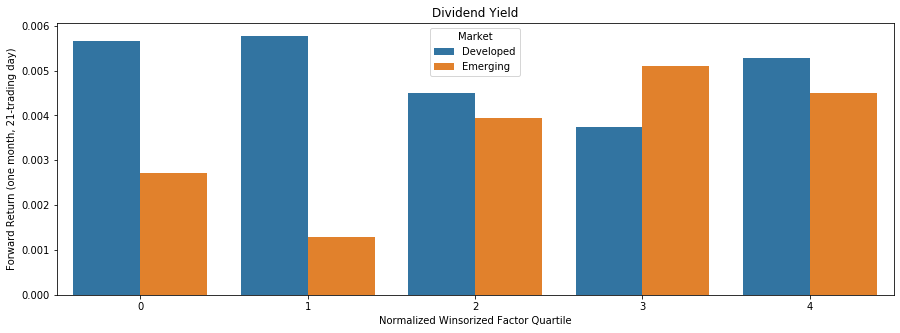

Price/Earning Ratio


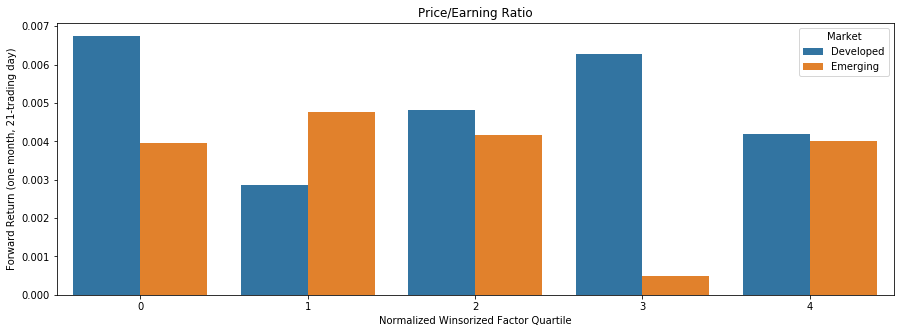

Price/Book Ratio


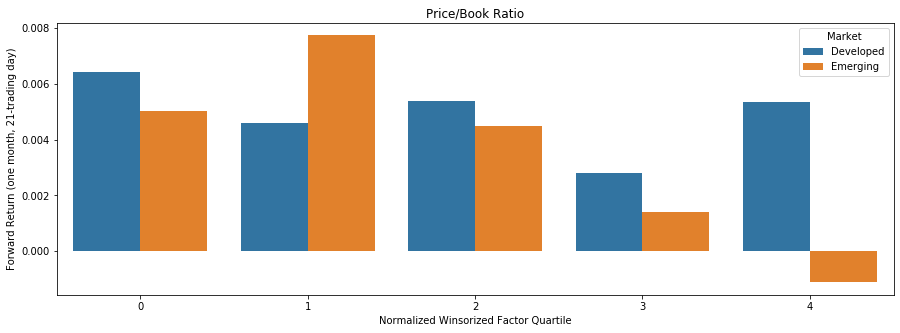

Price/Cash Flow Ratio


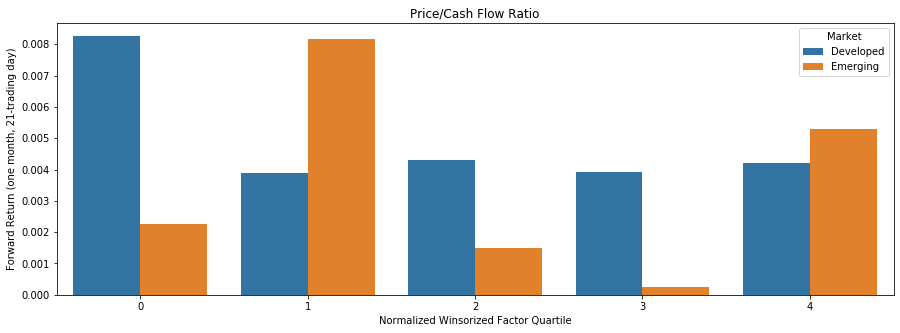

In [9]:
for factor_to_analyze in factors:
    description_factor_to_analyze = factor_description.loc[factor_to_analyze, 'Name']
    print(description_factor_to_analyze)

    #list all etf in datafrome
    all_etf_combined_df = pd.DataFrame()

    #going throw each etf forward return 
    for file in os.listdir('forward return'):
        fr_df = pd.read_csv('forward return/'+file, index_col='Date')
        fr_df['Ticker'] = file[:-4]
        try:
            factor_df = pd.read_csv('factor data/'+factor_to_analyze+'/'+file[:-4]+'.csv', index_col='Date')
            combined_df = fr_df.join(factor_df).rename({factor_to_analyze: 'Factor'}, axis=1)
            combined_df['Factor'] = combined_df['Factor'].fillna(method='ffill')
            all_etf_combined_df = pd.concat([all_etf_combined_df, combined_df.dropna().reset_index()], axis=0, ignore_index=True)
        except:
            continue

    all_etf_combined_df = all_etf_combined_df.join(all_tickers.set_index('Ticker'), on='Ticker').dropna()
    all_etf_combined_df = all_etf_combined_df.sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])[start_date_train:end_date_train]
    all_etf_combined_df['Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor Quartile'] = -1

    #combine all factors
    for date in all_etf_combined_df.index.get_level_values(0).unique():
        for market in ['Developed', 'Emerging']:
            n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]
            all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['Factor'], limits=1/n_etf*2)
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'])
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor Quartile'] = pd.qcut(all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'], 5, labels=False)
    # all_etf_combined_df.loc['2015-01-02'].drop('f_rtn', axis=1)
    #factor quantile study by developed and emerging market
    summary_df = all_etf_combined_df.reset_index().groupby(['Market', 'Normalized Winsorized Factor Quartile']).mean()[['f_rtn']]
    plt.figure(figsize=(15, 5))
    sns.barplot(x='Normalized Winsorized Factor Quartile', 
                y='Forward Return (one month, 21-trading day)', 
                hue='Market', 
                data=summary_df.reset_index().rename(factor_description['Name'].to_dict(), axis=1))
    plt.title(description_factor_to_analyze)
    plt.savefig('factor analysis results/'+factor_to_analyze+'.png')
    plt.show()
    summary_df.rename(factor_description['Name'].to_dict(), axis=1).T.to_excel('factor analysis results/'+factor_to_analyze+'.xlsx')

# Economic Factors

In [17]:
factors = ['debt_gdp', 'reer']

National Debt/GDP Ratio


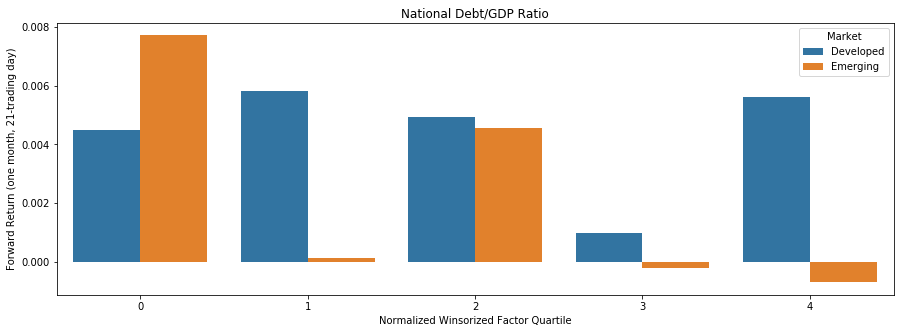

REER


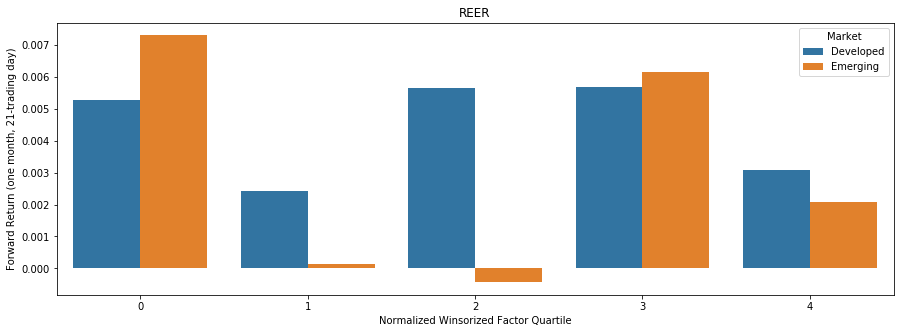

In [18]:
for factor_to_analyze in factors:
    description_factor_to_analyze = factor_description.loc[factor_to_analyze, 'Name']
    print(description_factor_to_analyze)

    #list all etf in datafrome
    all_etf_combined_df = pd.DataFrame()

    #going throw each etf forward return 
    for file in os.listdir('forward return'):
        fr_df = pd.read_csv('forward return/'+file, index_col='Date')
        fr_df['Ticker'] = file[:-4]
        try:
            factor_df = pd.read_csv('factor data/'+factor_to_analyze+'/'+file[:-4]+'.csv', index_col='Date')
            combined_df = fr_df.join(factor_df).rename({factor_to_analyze: 'Factor'}, axis=1)
            combined_df['Factor'] = combined_df['Factor'].fillna(method='ffill')
            all_etf_combined_df = pd.concat([all_etf_combined_df, combined_df.dropna().reset_index()], axis=0, ignore_index=True)
        except:
            continue

    all_etf_combined_df = all_etf_combined_df.join(all_tickers.set_index('Ticker'), on='Ticker').dropna()
    all_etf_combined_df = all_etf_combined_df.sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])[start_date_train:end_date_train]
    all_etf_combined_df['Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor Quartile'] = -1

    #combine all factors
    for date in all_etf_combined_df.index.get_level_values(0).unique():
        for market in ['Developed', 'Emerging']:
            n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]
            all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['Factor'], limits=1/n_etf*2)
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'])
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor Quartile'] = pd.qcut(all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'], 5, labels=False)
    # all_etf_combined_df.loc['2015-01-02'].drop('f_rtn', axis=1)
    #factor quantile study by developed and emerging market
    summary_df = all_etf_combined_df.reset_index().groupby(['Market', 'Normalized Winsorized Factor Quartile']).mean()[['f_rtn']]
    plt.figure(figsize=(15, 5))
    sns.barplot(x='Normalized Winsorized Factor Quartile', 
                y='Forward Return (one month, 21-trading day)', 
                hue='Market', 
                data=summary_df.reset_index().rename(factor_description['Name'].to_dict(), axis=1))
    plt.title(description_factor_to_analyze)
    plt.savefig('factor analysis results/'+factor_to_analyze+'.png')
    plt.show()
    summary_df.rename(factor_description['Name'].to_dict(), axis=1).T.to_excel('factor analysis results/'+factor_to_analyze+'.xlsx')

# Sentiment and Alternative Factors

Put/Call Ratio


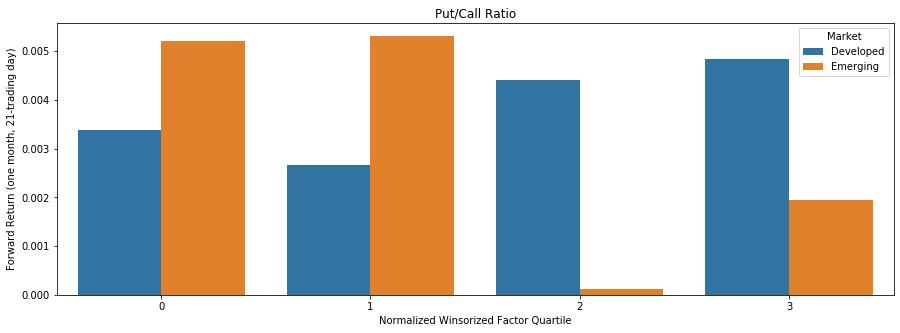

In [26]:
for factor_to_analyze in ['pc_ratio']:
    description_factor_to_analyze = factor_description.loc[factor_to_analyze, 'Name']
    print(description_factor_to_analyze)

    #list all etf in datafrome
    all_etf_combined_df = pd.DataFrame()

    #going throw each etf forward return 
    for file in os.listdir('forward return'):
        fr_df = pd.read_csv('forward return/'+file, index_col='Date')
        fr_df['Ticker'] = file[:-4]
        try:
            factor_df = pd.read_csv('factor data/'+factor_to_analyze+'/'+file[:-4]+'.csv', index_col='Date')
            combined_df = fr_df.join(factor_df).rename({factor_to_analyze: 'Factor'}, axis=1)
            combined_df['Factor'] = combined_df['Factor'].fillna(method='ffill')
            all_etf_combined_df = pd.concat([all_etf_combined_df, combined_df.dropna().reset_index()], axis=0, ignore_index=True)
        except:
            continue

    all_etf_combined_df = all_etf_combined_df.join(all_tickers.set_index('Ticker'), on='Ticker').dropna()
    all_etf_combined_df = all_etf_combined_df.sort_values(['Date', 'Market', 'Ticker']).set_index(['Date', 'Market', 'Ticker'])[start_date_train:end_date_train]
    all_etf_combined_df['Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor'] = np.nan
    all_etf_combined_df['Normalized Winsorized Factor Quartile'] = -1

    #combine all factors
    for date in all_etf_combined_df.index.get_level_values(0).unique():
        for market in ['Developed', 'Emerging']:
            n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]
            all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['Factor'], limits=1/n_etf*2)
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['Winsorized Factor'])
            all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor Quartile'] = pd.qcut(all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'], 4, labels=False)
    # all_etf_combined_df.loc['2015-01-02'].drop('f_rtn', axis=1)
    #factor quantile study by developed and emerging market
    summary_df = all_etf_combined_df.reset_index().groupby(['Market', 'Normalized Winsorized Factor Quartile']).mean()[['f_rtn']]
    plt.figure(figsize=(15, 5))
    sns.barplot(x='Normalized Winsorized Factor Quartile', 
                y='Forward Return (one month, 21-trading day)', 
                hue='Market', 
                data=summary_df.reset_index().rename(factor_description['Name'].to_dict(), axis=1))
    plt.title(description_factor_to_analyze)
    plt.savefig('factor analysis results/'+factor_to_analyze+'.png')
    plt.show()
    summary_df.rename(factor_description['Name'].to_dict(), axis=1).T.to_excel('factor analysis results/'+factor_to_analyze+'.xlsx')

In [25]:
pd.qcut(all_etf_combined_df.loc[date].loc[market]['Normalized Winsorized Factor'], 4, labels=False)

Ticker
ARGT    0
ECH     0
EIDO    3
EPU     0
EWM     3
EWT     2
EWW     1
EWY     1
EWZ     2
EZA     2
GREK    0
MCHI    1
THD     3
TUR     3
Name: Normalized Winsorized Factor, dtype: int64

In [23]:
all_etf_combined_df.loc['2015-09-16']

f_rtn  Factor  Winsorized Factor  \
Market    Ticker                                        
Developed EWA     0.037908  3.9409             3.4763   
          EWC     0.027879  3.4763             3.4763   
          EWD    -0.011056  0.3797             0.5303   
          EWG    -0.007877  0.9411             0.9411   
          EWH     0.030338  1.0298             1.0298   
          EWI     0.024701  0.5459             0.5459   
          EWJ     0.021084  0.3900             0.5303   
          EWK    -0.007006  0.7027             0.7027   
          EWL     0.004791  3.9094             3.4763   
          EWN     0.017663  0.5303             0.5303   
          EWP     0.032331  1.7860             1.7860   
          EWQ     0.025573  2.7593             2.7593   
          EWS     0.064716  0.7854             0.7854   
          EWU     0.023013  1.1510             1.1510   
          VOO     0.015644  0.8883             0.8883   
Emerging  ARGT   -0.008216  0.7284             0.7284   
          ECH    -0.000305  0.2065             0.3480   
          EIDO    0.120904  2.5000             2.5000   
          EPU     0.032826  0.1818             0.3480   
          EWM     0.060255  5.3020             2.5000   
          EWT     0.033031  1.0527             1.0527   
          EWW     0.014145  1.0450             1.0450   
          EWY     0.078166  1.0064             1.0064   
          EWZ    -0.019178  1.3669             1.3669   
          EZA     0.064309  1.5946             1.5946   
          GREK    0.003161  0.3480             0.3480   
          MCHI    0.054117  0.9986             0.9986   
          THD     0.047966  2.5000             2.5000   
          TUR     0.116107  7.5936             2.5000   

                  Normalized Winsorized Factor  \
Market    Ticker                                 
Developed EWA                         1.736262   
          EWC                         1.736262   
          EWD                        -0.861500   
          EWG                        -0.499259   
          EWH                        -0.421044   
          EWI                        -0.847744   
          EWJ                        -0.861500   
          EWK                        -0.709479   
          EWL                         1.736262   
          EWN                        -0.861500   
          EWP                         0.245767   
          EWQ                         1.104016   
          EWS                        -0.636554   
          EWU                        -0.314171   
          VOO                        -0.545818   
Emerging  ARGT                       -0.762407   
          ECH                        -1.232400   
          EIDO                        1.426448   
          EPU                        -1.232400   
          EWM                         1.426448   
          EWT                        -0.361726   
          EWW                        -0.371240   
          EWY                        -0.418931   
          EWZ                         0.026476   
          EZA                         0.307804   
          GREK                       -1.232400   
          MCHI                       -0.428568   
          THD                         1.426448   
          TUR                         1.426448   

                  Normalized Winsorized Factor Quartile  
Market    Ticker                                         
Developed EWA                                         4  
          EWC                                         4  
          EWD                                         0  
          EWG                                         2  
          EWH                                         2  
          EWI                                         1  
          EWJ                                         0  
          EWK                                         1  
          EWL                                         4  
          EWN                                         0  
      

In [77]:
#reorganize table by market
all_etf_combined_df.groupby(['Market'])

f_rtn    factor  winsorized factor  \
Date       Market    Ticker                                          
2015-01-02 Developed EDEN    0.015891  0.073955           0.073955   
                     EFNL    0.040772 -0.017174          -0.017174   
                     EIRL    0.029430  0.000940           0.000940   
                     EIS     0.007761 -0.010012          -0.010012   
                     ENOR    0.075848 -0.209467          -0.187163   
...                               ...       ...                ...   
2018-12-31 Emerging  PAK     0.120978 -0.300630          -0.300630   
                     QAT     0.052043  0.211525          -0.021842   
                     THD     0.097688 -0.075031          -0.075031   
                     TUR     0.176247 -0.413340          -0.309426   
                     UAE     0.038578 -0.143227          -0.143227   

                             normalized winsorized factor  \
Date       Market    Ticker                                 
2015-01-02 Developed EDEN                        1.420832   
                     EFNL                        0.243530   
                     EIRL                        0.477543   
                     EIS                         0.336056   
                     ENOR                       -1.952583   
...                                                   ...   
2018-12-31 Emerging  PAK                        -1.606755   
                     QAT                         1.376551   
                     THD                         0.807373   
                     TUR                        -1.700883   
                     UAE                         0.077608   

                             normalized winsorized factor quartile  
Date       Market    Ticker                                         
2015-01-02 Developed EDEN                                      NaN  
                     EFNL                                      NaN  
                     EIRL                                      NaN  
                     EIS                                       NaN  
                     ENOR                                      NaN  
...                                                            ...  
2018-12-31 Emerging  PAK                                       NaN  
                     QAT                                       NaN  
                     THD                                       NaN  
                     TUR                                       NaN  
                     UAE                                       NaN  

[46489 rows x 5 columns]

In [55]:
#specified start date in developed market
date = '2015-01-02'
market = 'Developed'

In [57]:
#combine all etf by market
n_etf = all_etf_combined_df.loc[date].loc[market].shape[0]

In [61]:
#listed the specified date and market
all_etf_combined_df.loc[date].loc[market]['winsorized factor'] = winsorize(all_etf_combined_df.loc[date].loc[market]['factor'], limits=1/n_etf*2)
all_etf_combined_df.loc[date].loc[market]['normalized winsorized factor'] = zscore(all_etf_combined_df.loc[date].loc[market]['winsorized factor'])

In [62]:
#show the result
all_etf_combined_df

f_rtn    factor  winsorized factor  \
Date       Market    Ticker                                          
2015-01-02 Developed EDEN    0.015891  0.073955           0.073955   
                     EFNL    0.040772 -0.017174          -0.017174   
                     EIRL    0.029430  0.000940           0.000940   
                     EIS     0.007761 -0.010012          -0.010012   
                     ENOR    0.075848 -0.209467          -0.187163   
...                               ...       ...                ...   
2018-12-31 Emerging  PAK     0.120978 -0.300630                NaN   
                     QAT     0.052043  0.211525                NaN   
                     THD     0.097688 -0.075031                NaN   
                     TUR     0.176247 -0.413340                NaN   
                     UAE     0.038578 -0.143227                NaN   

                             normalized winsorized factor  
Date       Market    Ticker                                
2015-01-02 Developed EDEN                        1.420832  
                     EFNL                        0.243530  
                     EIRL                        0.477543  
                     EIS                         0.336056  
                     ENOR                       -1.952583  
...                                                   ...  
2018-12-31 Emerging  PAK                              NaN  
                     QAT                              NaN  
                     THD                              NaN  
                     TUR                              NaN  
                     UAE                              NaN  

[46489 rows x 4 columns]

['ACWI.csv',
 'ARGT.csv',
 'ECH.csv',
 'EDEN.csv',
 'EFNL.csv',
 'EGPT.csv',
 'EIDO.csv',
 'EIRL.csv',
 'EIS.csv',
 'ENOR.csv',
 'ENZL.csv',
 'EPHE.csv',
 'EPOL.csv',
 'EPU.csv',
 'ERUS.csv',
 'EWA.csv',
 'EWC.csv',
 'EWD.csv',
 'EWG.csv',
 'EWH.csv',
 'EWI.csv',
 'EWJ.csv',
 'EWK.csv',
 'EWL.csv',
 'EWM.csv',
 'EWN.csv',
 'EWO.csv',
 'EWP.csv',
 'EWQ.csv',
 'EWS.csv',
 'EWT.csv',
 'EWU.csv',
 'EWW.csv',
 'EWY.csv',
 'EWZ.csv',
 'EZA.csv',
 'GREK.csv',
 'ICOL.csv',
 'INDA.csv',
 'KSA.csv',
 'MCHI.csv',
 'PAK.csv',
 'PGAL.csv',
 'QAT.csv',
 'THD.csv',
 'TUR.csv',
 'UAE.csv',
 'VOO.csv']